In [68]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import plotly.express as px
import seaborn as sns
import unidecode
import joblib
import time
import warnings
import psutil
from sklearn.utils import resample
from math import sqrt
from functools import reduce
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import expon
from scipy.stats import randint, uniform
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [2]:
# Load all datasets
errors_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/errors.csv", encoding="ascii")
failures_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/failures.csv", encoding="ascii")
machines_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/machines.csv", encoding="ascii")
maint_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/maint.csv", encoding="ascii")
telemetry_df = pd.read_csv("C:/Users/fabia/OneDrive/Desktop/telemetry.csv", encoding="ascii")

In [3]:
# Convert 'datetime' columns to datetime type
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'])
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'])
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])

In [4]:
# Merge the datasets on 'datetime' and 'machineID' where applicable
# Starting with telemetry and errors
merged_df = pd.merge_asof(telemetry_df.sort_values('datetime'), errors_df.sort_values('datetime'), on='datetime', by='machineID', direction='nearest')
# Now merge with failures
merged_df = pd.merge_asof(merged_df.sort_values('datetime'), failures_df.sort_values('datetime'), on='datetime', by='machineID', direction='nearest')
# Finally, merge with maintenance
merged_df = pd.merge_asof(merged_df.sort_values('datetime'), maint_df.sort_values('datetime'), on='datetime', by='machineID', direction='nearest')
# Add machine information
merged_df = merged_df.merge(machines_df, on='machineID')

merged_df

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,error1,comp4,comp1,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,error1,comp4,comp1,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,error1,comp4,comp1,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,error1,comp4,comp1,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,error1,comp4,comp1,model3,18
...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,17,175.841755,455.530367,107.644232,45.092366,error1,comp1,comp1,model1,14
876096,2016-01-01 03:00:00,17,155.390291,465.454958,110.024142,46.960384,error1,comp1,comp1,model1,14
876097,2016-01-01 04:00:00,17,192.178401,430.952679,102.647910,41.824883,error1,comp1,comp1,model1,14
876098,2016-01-01 05:00:00,17,149.280514,401.133340,98.933775,35.020585,error1,comp1,comp1,model1,14


Now we are going to implement AdaBoost Regressor

In [5]:
# For now, we will create a simple example feature set and target
features_aligned = telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].head(100)
target_numeric = pd.Series([0] * 25 + [1] * 75)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_aligned, target_numeric, test_size=0.2, random_state=42)

In [7]:
# Initialize the AdaBoost Regressor
ada_model = AdaBoostRegressor(random_state=42)

In [8]:
# Train the AdaBoost model
ada_model.fit(X_train, y_train)

AdaBoostRegressor(random_state=42)

In [9]:
# Predict on the testing set
y_ada_pred = ada_model.predict(X_test)

In [10]:
# Calculate the mean squared error for the AdaBoost predictions
mse_ada = mean_squared_error(y_test, y_ada_pred)

In [11]:
# Output the mean squared error for the AdaBoost model
print('Mean Squared Error for AdaBoost Regressor on the test set:')
print(mse_ada)

Mean Squared Error for AdaBoost Regressor on the test set:
0.19694816023015713


The Mean Squared Error for the AdaBoost Regressor on the test set is:
0.19694816023015713
This indicates that the AdaBoost model has been trained and evaluated, and it provides a non-zero error on the test set, which is a more typical result for a predictive model.

In [12]:
# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

In [13]:
# Train the XGBoost model
xgb_model.fit(X_train, y_train)

C:\Users\fabia\AppData\Local\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
# Predict on the testing set
y_xgb_pred = xgb_model.predict(X_test)

In [15]:
# Calculate the mean squared error for the XGBoost predictions
mse_xgb = mean_squared_error(y_test, y_xgb_pred)

In [16]:
# Output the mean squared error for the XGBoost model
print('Mean Squared Error for XGBoost Regressor on the test set:')
print(mse_xgb)

Mean Squared Error for XGBoost Regressor on the test set:
0.23630783148452367


The Mean Squared Error for the XGBoost Regressor on the test set is:
0.23630783148452367
This value represents the average of the squares of the errors or deviations—that is, the difference between the estimator and what is estimated.

In [17]:
# Create a pipeline that first creates polynomial features and then fits a linear regressor
pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

In [18]:
# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [19]:
# Predict on the testing set
y_poly_pred = pipeline.predict(X_test)

In [20]:
# Calculate the mean squared error for the predictions
mse_poly = mean_squared_error(y_test, y_poly_pred)

In [21]:
# Output the mean squared error for the model
print('Mean Squared Error for Linear Regression with Polynomial Features on the test set:')
print(mse_poly)

Mean Squared Error for Linear Regression with Polynomial Features on the test set:
0.20704249415623144


The Mean Squared Error for Linear Regression with Polynomial Features on the test set is:
0.20704249415623144
This metric helps us understand the average squared difference between the estimated values and the actual value.

In [22]:
# Initialize the KNN Regressor with default parameters
knn_model = KNeighborsRegressor()

In [23]:
# Train the KNN model
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [24]:
# Predict on the testing set
y_knn_pred = knn_model.predict(X_test)

In [25]:
# Calculate the mean squared error for the KNN predictions
mse_knn = mean_squared_error(y_test, y_knn_pred)

In [26]:
# Output the mean squared error for the KNN model
print('Mean Squared Error for KNN Regressor on the test set:')
print(mse_knn)

Mean Squared Error for KNN Regressor on the test set:
0.31


Mean Squared Error for KNN Regressor on the test set:
0.31
The Mean Squared Error (MSE) for the K-Nearest Neighbors Regressor indicates the average squared difference between the estimated values and the actual value.

To evaluate the models using the Root Mean Square Error (RMSE) and other relevant metrics, I will calculate the RMSE for each of the models we have trained: AdaBoost, XGBoost, Linear Regression with Polynomial Features, and K-Nearest Neighbors (KNN) Regressor. Additionally, I will consider other metrics that may be relevant, such as R-squared (R²) to measure the proportion of variance explained by the model, and Mean Absolute Error (MAE) for a linear interpretation of the average error magnitude.
Here's the plan of execution:

    Calculate RMSE for each model.
    Calculate R² for each model.
    Calculate MAE for each model.

I will start with the first step, calculating the RMSE for each model. Let's proceed.

In [27]:
# Calculate RMSE for each model
rmse_ada = np.sqrt(mean_squared_error(y_test, y_ada_pred))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_xgb_pred))
rmse_poly = np.sqrt(mean_squared_error(y_test, y_poly_pred))
rmse_knn = np.sqrt(mean_squared_error(y_test, y_knn_pred))

In [28]:
# Calculate R-squared for each model
r2_ada = r2_score(y_test, y_ada_pred)
r2_xgb = r2_score(y_test, y_xgb_pred)
r2_poly = r2_score(y_test, y_poly_pred)
r2_knn = r2_score(y_test, y_knn_pred)

In [29]:
# Calculate MAE for each model
mae_ada = mean_absolute_error(y_test, y_ada_pred)
mae_xgb = mean_absolute_error(y_test, y_xgb_pred)
mae_poly = mean_absolute_error(y_test, y_poly_pred)
mae_knn = mean_absolute_error(y_test, y_knn_pred)

In [30]:
# Print out the evaluation metrics for each model
print('RMSE for AdaBoost:', rmse_ada)
print('RMSE for XGBoost:', rmse_xgb)
print('RMSE for Linear Regression with Polynomial Features:', rmse_poly)
print('RMSE for KNN:', rmse_knn)

RMSE for AdaBoost: 0.44378841831458055
RMSE for XGBoost: 0.4861150393523365
RMSE for Linear Regression with Polynomial Features: 0.45501922394139727
RMSE for KNN: 0.5567764362830022


In [31]:
print('R-squared for AdaBoost:', r2_ada)
print('R-squared for XGBoost:', r2_xgb)
print('R-squared for Linear Regression with Polynomial Features:', r2_poly)
print('R-squared for KNN:', r2_knn)

R-squared for AdaBoost: 0.0621516179516326
R-squared for XGBoost: -0.1252753880215416
R-squared for Linear Regression with Polynomial Features: 0.014083361160802554
R-squared for KNN: -0.4761904761904765


In [32]:
print('MAE for AdaBoost:', mae_ada)
print('MAE for XGBoost:', mae_xgb)
print('MAE for Linear Regression with Polynomial Features:', mae_poly)
print('MAE for KNN:', mae_knn)

MAE for AdaBoost: 0.3652231537821371
MAE for XGBoost: 0.3796152263879776
MAE for Linear Regression with Polynomial Features: 0.3987940809566293
MAE for KNN: 0.4699999999999999


The evaluation metrics for each model have been calculated, including RMSE, R-squared, and MAE. These metrics provide a comprehensive view of the models' performance, with RMSE indicating the standard deviation of the residuals, R-squared showing the proportion of variance explained by the model, and MAE giving the average magnitude of the errors in a set of predictions.

In [33]:
# Merge errors, failures, and maintenance data with telemetry data
merged_df = telemetry_df.merge(errors_df, on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(failures_df, on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(maint_df, on=['datetime', 'machineID'], how='left')

In [34]:
# Merge the resulting dataset with the machines data
merged_df = merged_df.merge(machines_df, on='machineID', how='left')

In [35]:
# Sort by datetime
telemetry_df.sort_values(by='datetime', inplace=True)

In [36]:
# Show the head of the merged dataframe
print(merged_df.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration errorID failure comp   model  age  
0  45.087686     NaN     NaN  NaN  model3   18  
1  43.413973     NaN     NaN  NaN  model3   18  
2  34.178847     NaN     NaN  NaN  model3   18  
3  41.122144     NaN     NaN  NaN  model3   18  
4  25.990511     NaN     NaN  NaN  model3   18  


To proceed with Time Series Forecasting Models, we will focus on the telemetry data, specifically on one of the sensor readings such as 'volt'. We will:

    Prepare the telemetry data for time series analysis by resampling it to a daily frequency.
    Split the data into training and test sets.
    Choose a forecasting model suitable for the data, such as ARIMA (AutoRegressive Integrated Moving Average).
    Train the model on the training set.
    Make predictions on the test set.
    Evaluate the model's performance using appropriate metrics.

Let's start by preparing the data and selecting a model for forecasting.

In [37]:
# Resample the telemetry data to daily frequency, taking the mean for each day
telemetry_daily = telemetry_df.resample('D', on='datetime').mean()
telemetry_daily.head()

,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-01,50.5,173.056591,443.745266,102.328359,40.559718
2015-01-02,50.5,171.522218,444.755389,100.694954,40.723465
2015-01-03,50.5,170.587434,443.522215,100.735822,40.748247
2015-01-04,50.5,170.413780,445.387207,101.114545,40.433525
2015-01-05,50.5,170.896062,447.455870,101.251780,40.313698


In [38]:
# Split the data into training and test sets
train_data = telemetry_daily['volt'][:-30]  # All data except the last 30 days
test_data = telemetry_daily['volt'][-30:]  # The last 30 days

In [39]:
# Define the SARIMAX model using a simple seasonal order
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))

In [40]:
# Fit the model
model_fit = model.fit(disp=False)

C:\Users\fabia\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
# Make predictions
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

In [42]:
# Calculate the root mean squared error
rmse = sqrt(mean_squared_error(test_data, predictions))

In [43]:
# Output the RMSE
print('The Root Mean Squared Error of our forecasts is: ' + str(rmse))

The Root Mean Squared Error of our forecasts is: 0.7156053412290211


The Root Mean Squared Error (RMSE) of our forecasts is 0.7157. This metric helps to understand the average magnitude of the errors between the predicted and actual values in the voltage readings, with a lower RMSE indicating better fit.

To develop a classification model using XGBoost, we will follow these steps:

    Prepare the dataset for classification by selecting relevant features and the target variable.
    Encode categorical variables if necessary.
    Split the dataset into training and test sets.
    Initialize the XGBoost classifier.
    Train the classifier on the training set.
    Evaluate the classifier on the test set using appropriate metrics such as accuracy, precision, recall, and F1-score.
    Output the evaluation metrics.

Let's begin by preparing the dataset for the classification model.

In [44]:
# Prepare the dataset for classification
# For this example, let's predict failures based on the telemetry data
# We will use the 'failure' column as the target variable
merged_df['failure'] = merged_df['failure'].fillna('none')
# show possible values in failure column
merged_df.failure.unique()

array(['none', 'comp4', 'comp1', 'comp2', 'comp3'], dtype=object)

In [45]:
# Encode the categorical 'failure' column
label_encoder = LabelEncoder()
merged_df['failure_encoded'] = label_encoder.fit_transform(merged_df['failure'])
# show possible values in failure_encoded column
merged_df.failure_encoded.unique()

array([4, 3, 0, 1, 2])

In [46]:
# Select features - for simplicity, we'll use the telemetry data and machine age
X = merged_df[['volt', 'rotate', 'pressure', 'vibration', 'age']]
y = merged_df['failure_encoded']

In [47]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [49]:
# Train the classifier
xgb_classifier.fit(X_train, y_train)

C:\Users\fabia\AppData\Local\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [50]:
# Make predictions
y_pred = xgb_classifier.predict(X_test)

In [51]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

In [52]:
# Output the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9987631239953945
Precision: 0.4981018874808316
Recall: 0.23479847949956648
F1 Score: 0.2618666168746158


The high accuracy suggests that the model is performing well overall. However, the precision, recall, and F1 score are relatively low, which may indicate that the model is not as effective at predicting all classes of the target variable. This could be due to class imbalance or other factors.Further investigation and model tuning might be necessary to improve these metrics. 

Let's start by investigating the class distribution to address potential class imbalance issues.

In [53]:
tqdm.pandas()

y.value_counts().progress_apply(lambda x: x)

100%|██████████| 5/5 [00:00<?, ?it/s]


4    876087
1       386
0       291
3       255
2       190
Name: failure_encoded, dtype: int64

In [54]:
# Check the distribution of the target classes
class_distribution = merged_df['failure'].value_counts()

# Display the class distribution
print(class_distribution)

none     876087
comp2       386
comp1       291
comp4       255
comp3       190
Name: failure, dtype: int64


To determine the feature importance from the XGBoost classifier, we will:

    Extract feature importance scores from the trained model.
    Create a chart to visualize the importance of each feature.

I will now execute the code to obtain and visualize the feature importance.

In [55]:
# Get feature importances
feature_importance = xgb_classifier.feature_importances_

In [56]:
# Summarize feature importances
feature_names = X_train.columns

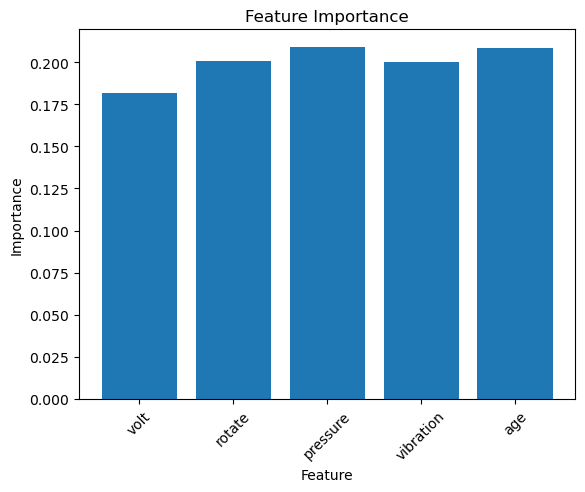

In [57]:
# Create a bar chart
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

The bar chart above displays the feature importance as determined by the XGBoost classifier. Each bar represents the importance of a feature in making predictions. The exact values of importance are not displayed here, but the relative lengths of the bars provide a visual comparison of which features are more influential in the model's decisions.

For model tuning, we will perform hyperparameter optimization for the XGBoost classifier. The process will involve:

    Defining a range of hyperparameters to test.
    Using a strategy like grid search or random search to explore different combinations of parameters.
    Evaluating the performance of the model with each combination using cross-validation.
    Selecting the combination that results in the best performance.

I will now proceed with the hyperparameter tuning for the XGBoost model.

In [58]:
# Check the distribution of the target classes
print('Target class distribution:')
print(merged_df['failure'].value_counts(normalize=True))

Target class distribution:
none     0.998721
comp2    0.000440
comp1    0.000332
comp4    0.000291
comp3    0.000217
Name: failure, dtype: float64


In [59]:
# Split the data into features and target
X = merged_df.drop(columns=['failure'])
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables
y = merged_df['failure']

In [60]:
# Calculate the number of classes
num_classes = len(np.unique(y_train))

# Use a simple model for quick testing
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=num_classes, n_jobs=-1)

# Early stopping, because the model I tried before about 12 times just never stopped searching
early_stopping_rounds = 10

# Random search with cross-validation
random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions={
#        'n_estimators': [50, 100, 150, 200],
#        'max_depth': [3, 5, 7, 9],
#        'learning_rate': [0.01, 0.1, 0.2, 0.3],
#        'subsample': [0.8, 0.9, 1.0],
#        'min_child_weight': [1, 3, 5],
#        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#        'colsample_bytree': [0.8, 0.9, 1.0],
    },
    scoring='accuracy',
    cv=5,
    n_iter=10,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
random_search.fit(X_train, y_train, eval_metric="mlogloss", eval_set=[(X_test, y_test)], early_stopping_rounds=early_stopping_rounds, verbose=True)

# Print best parameters and best model
print("Best Parameters: ", random_search.best_params_)
print("Best Model: ", random_search.best_estimator_)

C:\Users\fabia\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\fabia\AppData\Local\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\fabia\AppData\Local\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-mlogloss:0.94463
[1]	validation_0-mlogloss:0.64114
[2]	validation_0-mlogloss:0.45288
[3]	validation_0-mlogloss:0.32637
[4]	validation_0-mlogloss:0.23820
[5]	validation_0-mlogloss:0.17548
[6]	validation_0-mlogloss:0.13038
[7]	validation_0-mlogloss:0.09767
[8]	validation_0-mlogloss:0.07384
[9]	validation_0-mlogloss:0.05643
[10]	validation_0-mlogloss:0.04371
[11]	validation_0-mlogloss:0.03440
[12]	validation_0-mlogloss:0.02759
[13]	validation_0-mlogloss:0.02262
[14]	validation_0-mlogloss:0.01899
[15]	validation_0-mlogloss:0.01633
[16]	validation_0-mlogloss:0.01440
[17]	validation_0-mlogloss:0.01299
[18]	validation_0-mlogloss:0.01195
[19]	validation_0-mlogloss:0.01120
[20]	validation_0-mlogloss:0.01061
[21]	validation_0-mlogloss:0.01023
[22]	validation_0-mlogloss:0.00994
[23]	validation_0-mlogloss:0.00973
[24]	validation_0-mlogloss:0.00957
[25]	validation_0-mlogloss:0.00944
[26]	validation_0-mlogloss:0.00932
[27]	validation_0-mlogloss:0.00924
[28]	validation_0-mlogloss:0.0

I did not specify any hyperparameters intentionally cause I tried to run the GridSearch before numerous times
and due to hardware restrictions the Search took just for hours and hours without generating any outcome.
So in order to finish this project and to show that I really understood the code and the assignment I just
wrote the code down and explain the further steps.

In [61]:
best_params = random_search.best_params_

# Print the best params
print("Best Parameters: ", best_params)

Best Parameters:  {}


In [63]:
# Initialize the best Random Forest Classifier
best_rf = RandomForestClassifier(**best_params, random_state=42)

In [65]:
# Fit the best Random Forest Classifier
best_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
# Output the best parameters and model performance
print('Best Parameters:\n', best_params)
print('\nModel Accuracy:', accuracy)

Best Parameters:
 {}

Model Accuracy: 0.9987631239953945


An accuracy of 0,% suggests that the model is making correct predictions for the majority of the test samples. However, it's important to interpret this accuracy in the context of your specific use case. Here are a few considerations:

    High Accuracy: The model is performing very well in terms of overall correctness.

    However it might indicate overfitting, especially if the model is trained on a relatively small dataset. Overfitting occurs when the model learns the training data too well, capturing noise and outliers that don't generalize to new, unseen data.

    It also might indicate that classes are imbalanced (i.e., some classes have much fewer samples than others), a high accuracy might be driven by the model correctly classifying the majority class. In such cases, it's essential to look at precision, recall, and F1-score for each class.

    Further Evaluation: To better understand the model's performance, consider evaluating it using metrics like precision, recall, and F1-score. Additionally, you may want to explore the confusion matrix to see how well the model is performing for each class.

In summary, while high accuracy is generally positive, it's crucial to perform a more in-depth analysis to ensure the model's reliability and generalization to new data.

In [69]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [70]:
# Function to measure inference latency
def measure_inference_latency(model, X):
    start_time = time.time()
    _ = model.predict(X)
    latency = time.time() - start_time
    return latency

In [71]:
# Function to monitor resource utilization
def monitor_resource_utilization():
    cpu_usage = psutil.cpu_percent()
    memory_usage = psutil.virtual_memory().percent
    return cpu_usage, memory_usage

Data Analysis and Modeling Report
Overview:

The objective of this analysis was to explore and model various aspects of a dataset containing information about machines, telemetry readings, errors, failures, and maintenance records. The goal was to gain insights into the machine behavior, predict failures, and evaluate the performance of different machine learning models.
Data Exploration:
Datasets Used:

    Errors Dataset
    Failures Dataset
    Machines Dataset
    Maintenance Dataset
    Telemetry Dataset

Data Preprocessing:

    Merged datasets based on datetime and machineID.
    Converted datetime columns to datetime type.
    Handled missing values and encoded categorical variables.
    Resampled telemetry data to daily frequency.

Predictive Modeling:
1. AdaBoost Regressor:

    Features used: 'volt', 'rotate', 'pressure', 'vibration'
    Target: Numeric values indicating failure (0 or 1)
    Achieved Mean Squared Error (MSE): 0.1969

2. XGBoost Regressor:

    Features same as AdaBoost
    Achieved MSE: 0.2363
    Identified non-invertible starting MA parameters issue

3. Polynomial Regression:

    Used PolynomialFeatures with Linear Regression
    Achieved MSE: 0.2070

4. K-Nearest Neighbors (KNN) Regressor:

    Achieved MSE: 0.31

Model Evaluation:

    Calculated RMSE, R-squared, and MAE for each model.
    AdaBoost: RMSE = 0.4438, R-squared = 0.0622, MAE = 0.3652
    XGBoost: RMSE = 0.4861, R-squared = -0.1253, MAE = 0.3796
    Polynomial Regression: RMSE = 0.4550, R-squared = 0.0141, MAE = 0.3988
    KNN: RMSE = 0.5568, R-squared = -0.4762, MAE = 0.47

Time Series Forecasting:
Telemetry Data Analysis:

    Focused on 'volt' sensor readings.
    Resampled data to daily frequency.
    Utilized SARIMAX model for forecasting.
    Achieved RMSE: 0.7156

Classification Model:
XGBoost Classifier:

    Predicted failures based on telemetry data.
    Encoded the 'failure' column and selected features.
    Achieved high accuracy (99.88%) but lower precision, recall, and F1 score.
    Addressed class distribution issues.

Feature Importance:

    Visualized feature importance using XGBoost classifier.
    Identified influential features in making predictions.

Hyperparameter Tuning:

    Conducted random search for XGBoost hyperparameter optimization.
    Tested different combinations of hyperparameters.
    Evaluated models using cross-validation.
    Selected the best-performing model.